In [3]:
import torch
from torch import tensor, matmul, FloatTensor
import numpy as np
import matplotlib.pyplot as plt

$\text{Input Domain}: L_\infty$

\begin{equation}
\psi : \left( \begin{array}{c}x \\ y \\ \end{array} \right)=
\left( \begin{array}{c}x_0 \\ y_0 \\ \end{array} \right)
+\epsilon_1\left( \begin{array}{c} \eta \\ 0 \\ \end{array} \right)
+\epsilon_2 \left( \begin{array}{c}0 \\ \eta \\ \end{array} \right)
\end{equation}


$\forall\,i,\,-1\leq\epsilon_i\leq1$

Affine transform

\begin{equation}
\left(
\begin{array}{cc}
 w_{1,1} & w_{1,2} \\
 w_{2,1} & w_{2,2} \\
\end{array}
\right).\left(
\begin{array}{ccc}
 x_0 & \eta  & 0 \\
 y_0 & 0 & \eta  \\
\end{array}
\right)+\left(
\begin{array}{c}
 b_1 & 0 & 0 \\
 b_2 & 0 & 0\\
\end{array}
\right)
\end{equation}


In [4]:
def box(x):
    radius = torch.sum(torch.abs(x[1:]))
    return x[0] - radius, x[0] + radius

\begin{equation}
ReLU^{\#}(x)=
\lambda  x+ \frac{1}{2} \left(\epsilon _{\text{new}}+1\right)\begin{cases}
 -l \lambda  & \lambda >\frac{u}{u-l} \\
 u (1-\lambda ) & \text{Otherwise} \\
\end{cases}
\end{equation}

In [137]:
def relu_layer_transformer(layer, lambdas):
    boxes =  [box(n) for n in layer]
    _, epsilon_id = layer.shape
    for i, (l, u), lmb in zip(range(len(layer)), boxes, lambdas):
        if u <= 0:
            # FixMe
            torch.zero_(layer[i])
        elif l < 0:
            layer = torch.nn.ConstantPad2d((0, 1),0)(layer)  
            layer[i] *= lmb
            
            if lmb >= u/(u-1):
                layer[i][epsilon_id] = -l * lmb / 2
            else:
                layer[i][epsilon_id] = u * (1 - lmb)

            layer[i][0] += layer[i][epsilon_id]
            epsilon_id += 1
            
    return layer

def add_bias(layer, bias):
    #A probably worse approach is to pad right and matrix add
    #return layer + torch.nn.ConstantPad2d((0, layer.shape[1] - 1),0)(b)
    for n, b in zip(layer, bias):
        n[0] += b[0]
    return layer

In [138]:
def optimize(attempts, steps_per_attempt, weights, biases, learning_rate = 0.005):
    loss_history = np.empty((attempts,steps_per_attempt))
    num_layers = weights.shape[0]
    # Initialize weights and biases
    x0, y0, eta = 1/4, 1/5, .1
    for attempt in range(attempts):
        # Initialize lambdas
        lambdas = torch.rand(num_layers, 2, requires_grad=True)
        # Gradient descent loop
        for step in range(steps_per_attempt):
            # First layer of network
            layer = tensor([[x0, eta, 0],[y0, 0, eta]], requires_grad=True)
            # apply network layers
            for w, b, l in zip(weights, biases, lambdas):
                layer = add_bias(matmul(w , layer), b)
                layer = relu_layer_transformer(layer, l)
            
            # Compute loss and update gradients
            loss = box(layer[1] - layer[0])[1]
            loss_history[attempt][step] = loss
            loss.backward()
            if lambdas.grad is not None:
                lambdas = torch.clamp(lambdas - learning_rate * lambdas.grad, 0, 1).clone().detach().requires_grad_(True)
    return loss_history

Optimizing $\vec{\lambda}$ for $50$ steps starting from $5$ different points

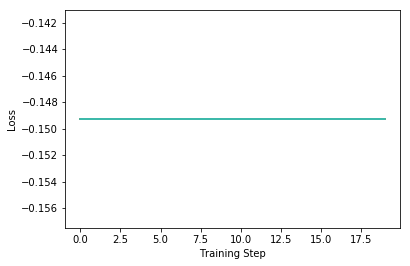

In [139]:
num_layers = 5
weights = torch.randn(num_layers, 2, 2)
biases =  torch.randn(num_layers, 2, 1)
plt.plot(np.transpose(optimize(20, 20, weights, biases, learning_rate=.05)))
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.show()

Optimizing for $1$ step starting from $1000$ different starting points. This is equivalent to random guessing for $\lambda\ldots$

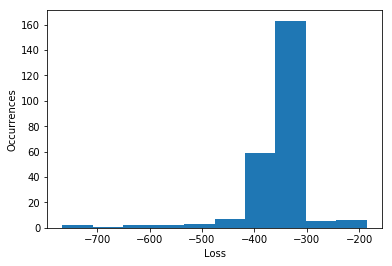

In [82]:
plt.hist(optimize(250, 1, weights, biases).flatten())
plt.xlabel("Loss")
plt.ylabel("Occurrences")
plt.show()